<a href="https://colab.research.google.com/github/AlkaSaliss/Pastai/blob/master/notebooks/YOLO_v5_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pastai 🍉

In this notebook, I'll train a YOLO v5 object detection on a dataset of watermelon (Pastèque in french, hence the (not so original 😁) name Pastai, ) that I created (videos taken from a small garden) and annotated using [CVAT](https://github.com/openvinotoolkit/cvat). 

The full version of the dataset contains around 4.7K images (train+val) for a size of  ~0.8Go. The small version (usefull for debugging) contains 48 images (train+val) with a size of 8Mo.

- The full version of the dataset can be downloaded from google drive with [the following link](https://drive.google.com/file/d/1KFG9HJWlu1I67Nv2BPVd5POHA1PisvKn/view?usp=sharing)
- The small version of the dataset can be downloaded using [the following link](https://drive.google.com/file/d/1res53-nBeCnF49J2W4KOH7CNdfICoTcw/view?usp=sharing). 


First we'll need the yolo training source code :

In [ ]:
# Clone the yolo v5 repository
!git clone https://github.com/ultralytics/yolov5

# install dependencies
%cd yolov5

# you may need to uncomment the export section in the yolov5/requirements.txt file to be able to use export script corretly at the end
%pip install -qr requirements.txt 

In [ ]:
import os
import glob
import pathlib
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

### Data loading
Let's load the data from google drive to local to reduce latency during model training.

In [ ]:
# package to download data from google drive
!pip install gdown

In [ ]:
import gdown

!mkdir -p "/content/data"
data_url = "https://drive.google.com/uc?id=1KFG9HJWlu1I67Nv2BPVd5POHA1PisvKn"
data_output  = "/content/data/pastai_annotated_data.tar.gz"
gdown.download(data_url, data_output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1KFG9HJWlu1I67Nv2BPVd5POHA1PisvKn
To: /content/data/pastai_annotated_data.tar.gz
822MB [00:26, 30.9MB/s]


'/content/data/pastai_annotated_data.tar.gz'

In [ ]:
# extract data
!tar -xvzf {data_output} -C "/content/data"

What is in the data folder  ¯\\_(ツ)_/¯ ? let's have a look

In [ ]:
list_images_train = sorted(glob.glob("/content/data/pastai_annotated_data/images/train/*.jpg"))
list_images_val = sorted(glob.glob("/content/data/pastai_annotated_data/images/val/*.jpg"))

list_labels_train = sorted(glob.glob("/content/data/pastai_annotated_data/labels/train/*.txt"))
list_labels_val = sorted(glob.glob("/content/data/pastai_annotated_data/labels/val/*.txt"))

assert len(list_images_train) == len(list_labels_train)
assert len(list_images_val) == len(list_labels_val)
print(f"We have {len(list_images_train)} training images and {len(list_images_val)} validation images")

We have 3984 training images and 704 validation images


In [ ]:
print(list_images_train[:5])
print()
print(list_labels_train[:5])

['/content/data/pastai_annotated_data/images/train/frame_000000.jpg', '/content/data/pastai_annotated_data/images/train/frame_000001.jpg', '/content/data/pastai_annotated_data/images/train/frame_000002.jpg', '/content/data/pastai_annotated_data/images/train/frame_000003.jpg', '/content/data/pastai_annotated_data/images/train/frame_000005.jpg']

['/content/data/pastai_annotated_data/labels/train/frame_000000.txt', '/content/data/pastai_annotated_data/labels/train/frame_000001.txt', '/content/data/pastai_annotated_data/labels/train/frame_000002.txt', '/content/data/pastai_annotated_data/labels/train/frame_000003.txt', '/content/data/pastai_annotated_data/labels/train/frame_000005.txt']


Each sample consist of a jpg image file (e.g. frame_000000.jpg) with a corresponding text file as label (e.g. frame_000000.txt). The label file contains the class (here we only have one class 'watermelon', so all class labels will be equal to 0) and the bounding box(es) :

In [ ]:
!cat {list_labels_train[0]}

0 0.453299 0.475883 0.494569 0.308266


In the above label example, The first number (0) is the class label, the 2nd and 3rd numbers are bounding box center point x-y coordinates (in terms of percentage of image width and height), and the 4th and 5th numbers are bounding box width and height respectively (in terms of percentage of image width and height).

Let's visualize sample data

In [ ]:
def unnormalize_coords(h, w, coords):
    h1, w1 = h*coords[-1], w*coords[-2]
    x_center, y_center = w*coords[1], h*coords[2]
    x_min, y_min = int(x_center - w1/2), int(y_center - h1/2)
    x_max, y_max = int(x_center + w1/2), int(y_center + h1/2)
    return x_min, y_min, x_max, y_max


def annotate_image(path_img, path_label):
    img = cv2.imread(path_img)
    h, w = img.shape[:2]
    with open(path_label) as f:
        labels = [[float(num) for num in item.split()] for item in f.readlines()]
    for coord in labels:
        x_min, y_min, x_max, y_max = unnormalize_coords(h, w, coord)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max),
                      color=(0, 255, 0), thickness=5)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def viz_annotated(list_images, list_labels):
    rnd_idx = random.sample(range(len(list_labels)), 9)
    list_annotated = [annotate_image(list_images[idx], list_labels[idx]) for idx in rnd_idx]
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))
    axes = axes.ravel()
    for i, im in enumerate(list_annotated):
        axes[i].imshow(im)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

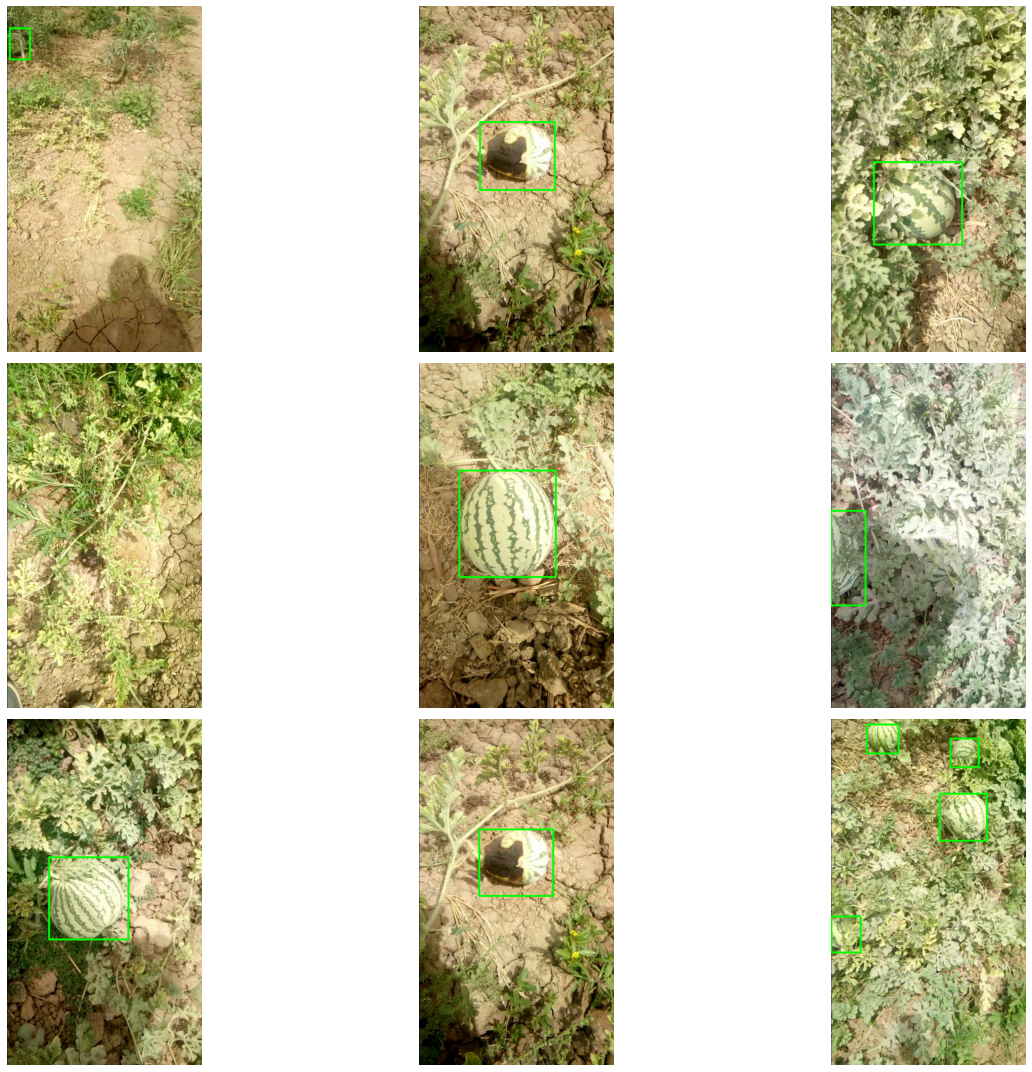

In [ ]:
viz_annotated(list_images_train, list_labels_train)

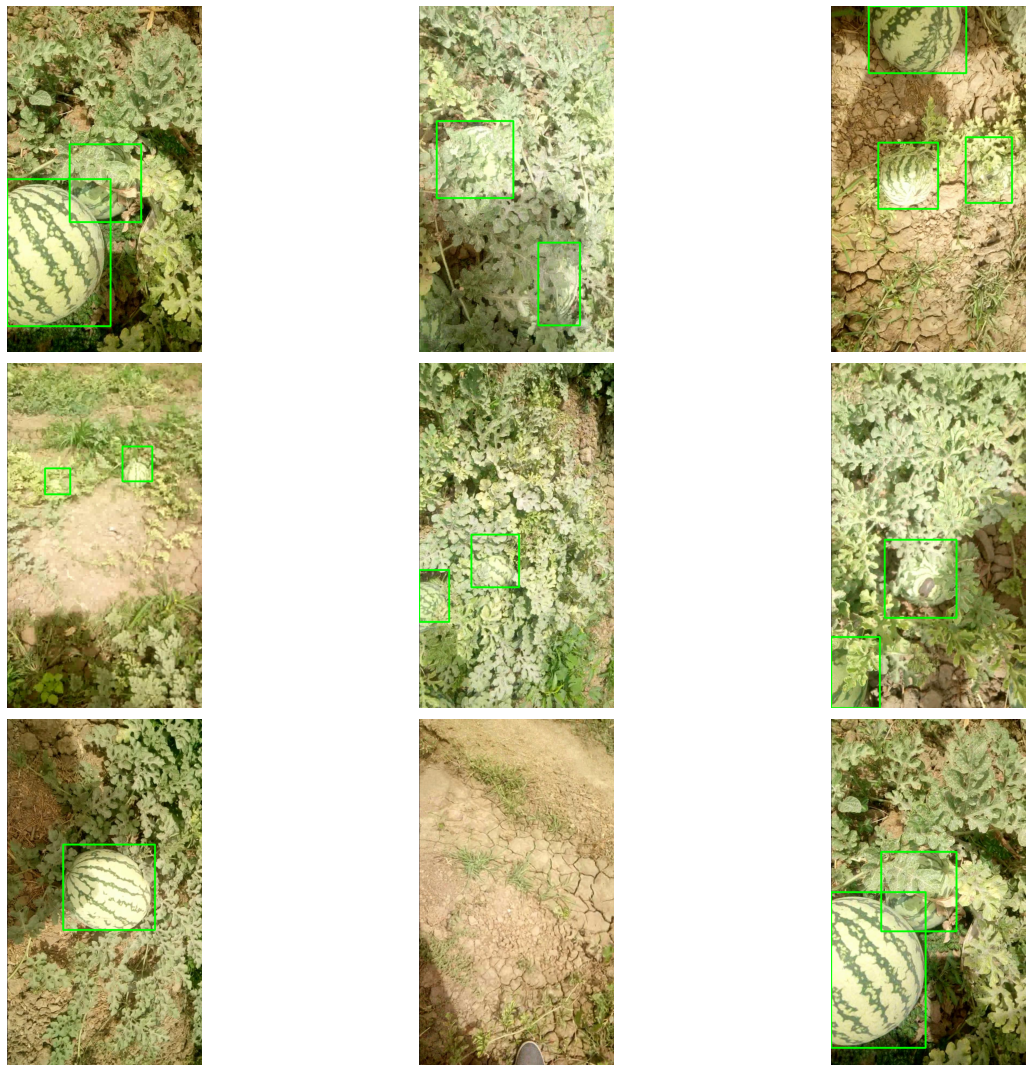

In [ ]:
viz_annotated(list_images_val, list_labels_val)

### Training YOLO v5

Next we'll finetune a YOLO v5 object detection algorithm on our custom data.

We need to create a data configuration yaml file 

In [ ]:
data_config = """
# path to train and validation data
train: /content/data/pastai_annotated_data/images/train
val: /content/data/pastai_annotated_data/images/val

# number of classes
nc: 1

# class names
names: ['watermelon']
"""
with open("pastai_data_config.yaml", "w") as f:
    f.writelines(data_config)

And the training can start 🎆 !



1. Large model

In [ ]:
%%time

!python train.py --img-size 256 \
    --rect \
    --batch-size 32 \
    --epochs 100 \
    --data "./pastai_data_config.yaml" \
    --weights yolov5x.pt \
    --cache-images \
    --device 0 \
    --project "/content/drive/MyDrive/Pastai/output/train/yolo" \


github: ⚠️ WARNING: code is out of date by 4 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
Resuming training from /content/drive/MyDrive/Pastai/output/train/yolo/exp/weights/best.pt
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=True, cfg='', data='./pastai_data_config.yaml', device='0', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='/content/drive/MyDrive/Pastai/output/train/yolo', quad=False, rect=True, resume=True, save_dir='/content/drive/MyDrive/Pastai/output/train/yolo/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset

2. Medium model

In [ ]:
%%time

!python train.py --img-size 256 \
    --rect \
    --batch-size 32 \
    --epochs 100 \
    --data "./pastai_data_config.yaml" \
    --weights yolov5m.pt \
    --cache-images \
    --device 0 \
    --project "/content/drive/MyDrive/Pastai/output/train/yolo" 


github: ⚠️ WARNING: code is out of date by 4 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=True, cfg='', data='./pastai_data_config.yaml', device='0', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='/content/drive/MyDrive/Pastai/output/train/yolo', quad=False, rect=True, resume=False, save_dir='/content/drive/MyDrive/Pastai/output/train/yolo/exp2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='yolov5m.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboa

3. Small moodel

In [ ]:
%%time

!python train.py --img-size 256 \
    --rect \
    --batch-size 32 \
    --epochs 100 \
    --data "./pastai_data_config.yaml" \
    --weights yolov5s.pt \
    --cache-images \
    --device 0 \
    --project "/content/drive/MyDrive/Pastai/output/train/yolo" 


github: ⚠️ WARNING: code is out of date by 4 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=True, cfg='', data='./pastai_data_config.yaml', device='0', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='/content/drive/MyDrive/Pastai/output/train/yolo', quad=False, rect=True, resume=False, save_dir='/content/drive/MyDrive/Pastai/output/train/yolo/exp3', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboa

### Model evaluation.

In this section we evaluate the 3 finetuned models, i.e. yolo small, medium and large.

1. Yolo large

In [ ]:
!python test.py --weights "/content/drive/MyDrive/Pastai/output/train/yolo/exp/weights/best.pt" \
    --data "./pastai_data_config.yaml" \
    --img 256 

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./pastai_data_config.yaml', device='', exist_ok=False, img_size=256, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/drive/MyDrive/Pastai/output/train/yolo/exp/weights/best.pt'])
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 476 layers, 87198694 parameters, 0 gradients, 217.1 GFLOPS
val: Scanning '/content/data/pastai_annotated_data/labels/val.cache' images and labels... 704 found, 0 missing, 63 empty, 0 corrupted: 100% 704/704 [00:00<00:00, 5700366.83it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 22/22 [00:10<00:00,  2.16it/s]
                 all         704        1435       0.965       0.974       0.989       0.713
Speed: 2.6/1.5/4.1 ms inference/NMS/total per 256x256 i

2. Yolo medium

In [ ]:
!python test.py --weights "/content/drive/MyDrive/Pastai/output/train/yolo/exp2/weights/best.pt" \
    --data "./pastai_data_config.yaml" \
    --img 256 

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./pastai_data_config.yaml', device='', exist_ok=False, img_size=256, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/drive/MyDrive/Pastai/output/train/yolo/exp2/weights/best.pt'])
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 308 layers, 21037638 parameters, 0 gradients, 50.3 GFLOPS
val: Scanning '/content/data/pastai_annotated_data/labels/val.cache' images and labels... 704 found, 0 missing, 63 empty, 0 corrupted: 100% 704/704 [00:00<00:00, 5700366.83it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 22/22 [00:10<00:00,  2.19it/s]
                 all         704        1435       0.969       0.957       0.983       0.683
Speed: 1.5/1.5/3.0 ms inference/NMS/total per 256x256 i

3. Yolo small

In [ ]:
!python test.py --weights "/content/drive/MyDrive/Pastai/output/train/yolo/exp3/weights/best.pt" \
    --data "./pastai_data_config.yaml" \
    --img 256 

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./pastai_data_config.yaml', device='', exist_ok=False, img_size=256, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/drive/MyDrive/Pastai/output/train/yolo/exp3/weights/best.pt'])
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
val: Scanning '/content/data/pastai_annotated_data/labels/val.cache' images and labels... 704 found, 0 missing, 63 empty, 0 corrupted: 100% 704/704 [00:00<00:00, 6088226.84it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 22/22 [00:10<00:00,  2.17it/s]
                 all         704        1435       0.948       0.944       0.972       0.644
Speed: 0.9/1.7/2.5 ms inference/NMS/total per 256x256 im

As expected, yolo large has best results (mean average precision mAP), followed by yolo medium, then yolo small.

However given that the performance gap is not significant, one may prefer go with yolo small in a resource-constrained environment, such as edge devices.

| model       | mAP   | Precision | Recall | Inference time (ms) |
|-------------|-------|-----------|--------|---------------------|
| yolo large  | 0.989 | 0.965     | 0.974  | 4.1                 |
| yolo medium | 0.983 | 0.969     | 0.957  | 3                   |
| yolo small  | 0.972 | 0.948     | 0.944  | 2.5                 |

### Export trained model in optimized format
* TorchScript
* Onnx

In [ ]:
!python ./models/export.py --weights "/content/drive/MyDrive/Pastai/output/train/yolo/exp3/weights/best.pt" \
    --img-size 256 \
    --batch-size 1 \
    --optimize \
    --dynamic \
    --include 'torchscript' 'onnx'

Namespace(batch_size=1, device='cpu', dynamic=True, half=False, img_size=[256, 256], include=['torchscript', 'onnx'], inplace=False, opset_version=12, optimize=True, simplify=False, train=False, weights='/content/drive/MyDrive/Pastai/output/train/yolo/exp3/weights/best.pt')
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CPU

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS

PyTorch: starting from /content/drive/MyDrive/Pastai/output/train/yolo/exp3/weights/best.pt (14.3 MB)

TorchScript: starting export with torch 1.8.1+cu101...
/content/yolov5/models/yolo.py:51: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4] or self.onnx_dynamic:
TorchScript: export success, saved as /content/drive/MyD

In [ ]:
!python ./models/export.py --weights "/content/drive/MyDrive/Pastai/output/train/yolo/exp2/weights/best.pt" \
    --img-size 256 \
    --batch-size 1 \
    --optimize \
    --dynamic \
    --include 'torchscript' 'onnx'

Namespace(batch_size=1, device='cpu', dynamic=True, half=False, img_size=[256, 256], include=['torchscript', 'onnx'], inplace=False, opset_version=12, optimize=True, simplify=False, train=False, weights='/content/drive/MyDrive/Pastai/output/train/yolo/exp2/weights/best.pt')
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CPU

Fusing layers... 
Model Summary: 308 layers, 21037638 parameters, 0 gradients, 50.3 GFLOPS

PyTorch: starting from /content/drive/MyDrive/Pastai/output/train/yolo/exp2/weights/best.pt (42.4 MB)

TorchScript: starting export with torch 1.8.1+cu101...
/content/yolov5/models/yolo.py:51: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4] or self.onnx_dynamic:
TorchScript: export success, saved as /content/drive/My

In [ ]:
!python ./models/export.py --weights "/content/drive/MyDrive/Pastai/output/train/yolo/exp/weights/best.pt" \
    --img-size 256 \
    --batch-size 1 \
    --optimize \
    --dynamic \
    --include 'torchscript' 'onnx'

Namespace(batch_size=1, device='cpu', dynamic=True, half=False, img_size=[256, 256], include=['torchscript', 'onnx'], inplace=False, opset_version=12, optimize=True, simplify=False, train=False, weights='/content/drive/MyDrive/Pastai/output/train/yolo/exp/weights/best.pt')
YOLOv5 🚀 v5.0-115-g407dc50 torch 1.8.1+cu101 CPU

Fusing layers... 
Model Summary: 476 layers, 87198694 parameters, 0 gradients, 217.1 GFLOPS

PyTorch: starting from /content/drive/MyDrive/Pastai/output/train/yolo/exp/weights/best.pt (175.0 MB)

TorchScript: starting export with torch 1.8.1+cu101...
/content/yolov5/models/yolo.py:51: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4] or self.onnx_dynamic:
TorchScript: export success, saved as /content/drive/My